<a href="https://colab.research.google.com/github/khresth/Layout-Organization-Recognition/blob/main/CNN_Layout_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries and Import Dependencies
This cell installs the required libraries (Tesseract, Python packages) and imports necessary modules for the project.

In [21]:
"""
Installing Tesseract OCR and its Spanish language pack for text detection, along with Python libraries for image processing, machine learning, and visualization.
Adding modules for file handling (os), image processing (cv2, numpy), machine learning (tensorflow), PDF conversion (pdf2image), plotting (matplotlib), data splitting (sklearn), and OCR (pytesseract).
"""

!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-spa
!pip install tensorflow opencv-python pdf2image numpy matplotlib pytesseract
!tesseract --list-langs

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-spa is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
TensorFlow version: 2.18.0
List of available languages (3):
eng
osd
spa


## Define File Paths and PDF-to-Image Conversion Function
This cell defines the paths to the PDF files and a function to convert PDFs to images (first 3 pages per source).

In [22]:
"""
Defining the list of PDF files from the RenAIssance dataset (Early modern printed sources).
Implements pdf_to_images function to convert the first 3 pages of each PDF to JPEG images using pdf2image.
Saves images to an 'images' directory and returns their file paths for further processing.
"""

pdf_files = [
    "Buendia - Instruccion.pdf",
    "Constituciones sinodales Calahorra 1602.pdf",
    "Ezcaray - Vozes.pdf",
    "Mendo - Principe perfecto.pdf",
    "Paredes - Reglas generales.pdf",
    "PORCONES.228.35 – 1636.pdf"
]

def pdf_to_images(pdf_path, output_dir="images", max_pages=3):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    images = convert_from_path(pdf_path, first_page=1, last_page=max_pages, dpi=150)
    image_paths = []
    for i, image in enumerate(images):
        image_path = f"{output_dir}/{pdf_path.split('.')[0]}_page_{i+1}.jpg"
        image.save(image_path, 'JPEG')
        image_paths.append(image_path)
    return image_paths

## Preprocess Images and Annotate with Tesseract
This cell defines a function to preprocess images (resize, normalize) and annotate them with Tesseract OCR to detect the main text bounding box.

In [23]:
"""
Defining the preprocess_and_annotate function to:
1. Load and preprocess images (convert to grayscale, resize to 224x224, normalize to [0, 1]).
2. Use Tesseract OCR to detect word-level text regions, merging them into a single bounding box for the main text.
3. Normalize bounding box coordinates to [0, 1] relative to the original image dimensions.
4. Ensure the output image shape is (224, 224, 1) for model input.
This falls back to English if Spanish language data is unavailable.
"""

def preprocess_and_annotate(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    h_orig, w_orig = img.shape
    try:
        d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang='spa')
    except pytesseract.TesseractError:
        print("Spanish language data not found, falling back to English...")
        d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang='eng')
    boxes = []
    for i in range(len(d['level'])):
        if d['level'][i] == 5:
            conf = int(d['conf'][i])
            if conf > 50:
                x, y, w, h = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
                boxes.append([x, y, x+w, y+h])

    if boxes:
        boxes = np.array(boxes)
        x_min = np.min(boxes[:, 0])
        y_min = np.min(boxes[:, 1])
        x_max = np.max(boxes[:, 2])
        y_max = np.max(boxes[:, 3])
        x_min = max(0, x_min - 10)
        y_min = max(0, y_min - 10)
        x_max = min(w_orig, x_max + 10)
        y_max = min(h_orig, y_max + 10)
        bbox = [x_min/w_orig, y_min/h_orig, x_max/w_orig, y_max/h_orig]
    else:
        bbox = [0.1, 0.1, 0.9, 0.9]

    img = cv2.resize(img, target_size) / 255.0
    img = img[..., np.newaxis]
    if img.shape != (224, 224, 1):
        raise ValueError(f"Image shape mismatch after preprocessing: {img.shape}")
    return img, bbox

## Define Data Augmentation Function
This cell defines a function to augment images (rotation, brightness adjustment) while ensuring shape consistency.

In [24]:
"""
Defining augment_image function to:
1. Apply random rotation (up to ±10 degrees) and brightness adjustments (0.8 to 1.2 scaling) to increase dataset diversity.
2. Ensure the input and output image shapes remain (224, 224, 1) to maintain consistency for model training.
3. Clip pixel values to [0, 1] to avoid invalid values after augmentation.
"""

def augment_image(img):
    if img.shape != (224, 224, 1):
        img = img.reshape(224, 224, 1)
    angle = np.random.uniform(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img.squeeze(), M, (w, h))
    img = img * np.random.uniform(0.8, 1.2)
    img = np.clip(img, 0, 1)
    img = img[..., np.newaxis]
    if img.shape != (224, 224, 1):
        raise ValueError(f"Image shape mismatch after augmentation: {img.shape}")
    return img

## Load and Prepare Dataset
This cell loads the dataset by converting PDFs to images, preprocessing them, applying augmentation, and splitting into training and validation sets.

In [25]:
"""
Loading the dataset by:
1. Converting PDFs to images using pdf_to_images.
2. Preprocessing each image and annotating with preprocess_and_annotate to get images and bounding boxes.
3. Augmenting each image to double the dataset size (from 18 to 36 images) for better generalization.
4. Debugging image shapes to ensure consistency (all should be 224x224x1).
5. Splitting the dataset into training (80%) and validation (20%) sets using train_test_split.
6. Converting lists to NumPy arrays for model training and verifying final shapes.
"""

dataset = []
for pdf in pdf_files:
    image_paths = pdf_to_images(pdf)
    for path in image_paths:
        img, bbox = preprocess_and_annotate(path)
        dataset.append((img, bbox))
        aug_img = augment_image(img.copy())
        dataset.append((aug_img, bbox))

print("Checking shapes in dataset...")
for i, (img, bbox) in enumerate(dataset):
    if img.shape != (224, 224, 1):
        print(f"Shape mismatch at index {i}: {img.shape}")
    else:
        print(f"Index {i}: Shape OK - {img.shape}")

train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_images = np.array([img for img, _ in train_data])
train_bboxes = np.array([bbox for _, bbox in train_data])
val_images = np.array([img for img, _ in val_data])
val_bboxes = np.array([bbox for _, bbox in val_data])

print(f"train_images shape: {train_images.shape}")
print(f"val_images shape: {val_images.shape}")

Checking shapes in dataset...
Index 0: Shape OK - (224, 224, 1)
Index 1: Shape OK - (224, 224, 1)
Index 2: Shape OK - (224, 224, 1)
Index 3: Shape OK - (224, 224, 1)
Index 4: Shape OK - (224, 224, 1)
Index 5: Shape OK - (224, 224, 1)
Index 6: Shape OK - (224, 224, 1)
Index 7: Shape OK - (224, 224, 1)
Index 8: Shape OK - (224, 224, 1)
Index 9: Shape OK - (224, 224, 1)
Index 10: Shape OK - (224, 224, 1)
Index 11: Shape OK - (224, 224, 1)
Index 12: Shape OK - (224, 224, 1)
Index 13: Shape OK - (224, 224, 1)
Index 14: Shape OK - (224, 224, 1)
Index 15: Shape OK - (224, 224, 1)
Index 16: Shape OK - (224, 224, 1)
Index 17: Shape OK - (224, 224, 1)
Index 18: Shape OK - (224, 224, 1)
Index 19: Shape OK - (224, 224, 1)
Index 20: Shape OK - (224, 224, 1)
Index 21: Shape OK - (224, 224, 1)
Index 22: Shape OK - (224, 224, 1)
Index 23: Shape OK - (224, 224, 1)
Index 24: Shape OK - (224, 224, 1)
Index 25: Shape OK - (224, 224, 1)
Index 26: Shape OK - (224, 224, 1)
Index 27: Shape OK - (224, 224, 1)


## Build and Compile the CNN Model
This cell defines the CNN model for bounding box regression, a custom loss function to favor larger boxes, and compiles the model.

In [26]:
"""
Defines build_layout_model function to create a CNN with:
1. Conv2D layers (32, 64, 128, 256 filters) with ReLU activation and MaxPooling for spatial feature extraction.
2. Flatten and Dense layers with dropout (0.5) for regularization.
3. A final Dense layer with sigmoid activation to output 4 normalized bounding box coordinates.
Combining Mean Squared Error (MSE) with a size penalty, encouraging larger boxes for main text regions.
Compiles the model with the Adam optimizer, custom loss, and MAE metric, and prints a summary.
"""

def build_layout_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def custom_bbox_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError()
    mse = mse_loss(y_true, y_pred)
    pred_width = y_pred[:, 2] - y_pred[:, 0]
    pred_height = y_pred[:, 3] - y_pred[:, 1]
    size_penalty = tf.reduce_mean(tf.maximum(0.0, 0.5 - pred_width)) + tf.reduce_mean(tf.maximum(0.0, 0.5 - pred_height))
    return mse + 0.1 * size_penalty

model = build_layout_model((224, 224, 1))
model.compile(optimizer='adam', loss=custom_bbox_loss, metrics=['mae'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,266,564 (50.61 MB)

 Trainable params: 13,266,564 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model
This cell trains the model with early stopping to prevent overfitting.

In [27]:
"""
Trains the CNN model on the training data with:
1. Validation data for monitoring performance.
2. 50 epochs and a batch size of 8 for stable updates on the small dataset.
3. Early stopping (patience = 5) to stop training if validation loss doesn't improve, restoring the best weights.
"""

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_images, train_bboxes,
                    validation_data=(val_images, val_bboxes),
                    epochs=50, batch_size=8,
                    callbacks=[early_stopping])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.1910 - mae: 0.3027 - val_loss: 0.0048 - val_mae: 0.0424
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0582 - mae: 0.1159 - val_loss: 0.0048 - val_mae: 0.0424
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0398 - mae: 0.0953 - val_loss: 0.0048 - val_mae: 0.0424
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0229 - mae: 0.0877 - val_loss: 0.0048 - val_mae: 0.0424
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0589 - mae: 0.1228 - val_loss: 0.0048 - val_mae: 0.0431
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0169 - mae: 0.0791 - val_loss: 0.0048 - val_mae: 0.0424
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0223 - mae: 0.0866 - val_loss: 0.0048 - val_mae: 0.0425
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0159 - mae: 0.0807 - val_loss: 0.0047 - val_mae: 0.0431
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0119 - mae: 0.0709 - val_loss: 0.0048 

## Evaluate the Model
This cell defines a function to compute IoU and evaluates the model on the validation set using IoU, precision, and recall.

In [28]:
"""
Defines compute_iou function to calculate the Intersection over Union (IoU) between predicted and true bounding boxes.
Evaluates the model on the validation set by:
1. Predicting bounding boxes for validation images.
2. Computing the average IoU across the validation set.
3. Calculating precision and recall using an IoU threshold of 0.5 (standard for object detection).
Prints the evaluation metrics for review.
"""

def compute_iou(pred_boxes, true_boxes):
    x1 = np.maximum(pred_boxes[:, 0], true_boxes[:, 0])
    y1 = np.maximum(pred_boxes[:, 1], true_boxes[:, 1])
    x2 = np.minimum(pred_boxes[:, 2], true_boxes[:, 2])
    y2 = np.minimum(pred_boxes[:, 3], true_boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
    union = pred_area + true_area - intersection
    iou = intersection / (union + 1e-6)
    return np.mean(iou)

val_preds = model.predict(val_images)
iou_score = compute_iou(val_preds, val_bboxes)
print(f"Validation IoU: {iou_score:.4f}")

threshold = 0.5
ious = [compute_iou(pred[np.newaxis, :], true[np.newaxis, :]) for pred, true in zip(val_preds, val_bboxes)]
precision = np.mean([1 if iou > threshold else 0 for iou in ious])
recall = precision
print(f"Precision (IoU > {threshold}): {precision:.4f}")
print(f"Recall (IoU > {threshold}): {recall:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Validation IoU: 0.8214
Precision (IoU > 0.5): 1.0000
Recall (IoU > 0.5): 1.0000


## Visualize Predictions
This cell visualizes the predicted and true bounding boxes on a validation sample to assess the model's performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


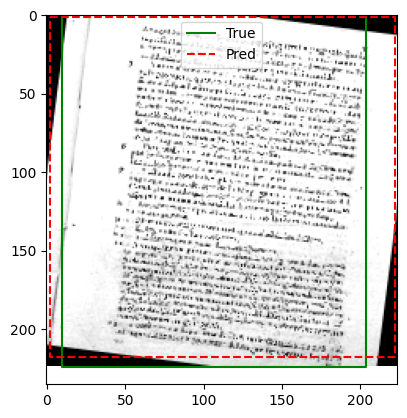

In [29]:
"""
Visualizes the model's performance on a single validation sample by:
1. Plotting the image in grayscale.
2. Overlaying the true bounding box (green solid line) and predicted bounding box (red dashed line).
3. Adding a legend to distinguish between true and predicted boxes.
Helps visually assess the alignment between predicted and true bounding boxes.
"""

sample_img, sample_true_bbox = val_data[0]
sample_pred_bbox = model.predict(sample_img[np.newaxis, ...])[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.plot([sample_true_bbox[0]*224, sample_true_bbox[2]*224, sample_true_bbox[2]*224, sample_true_bbox[0]*224, sample_true_bbox[0]*224],
         [sample_true_bbox[1]*224, sample_true_bbox[1]*224, sample_true_bbox[3]*224, sample_true_bbox[3]*224, sample_true_bbox[1]*224], 'g-', label='True')
plt.plot([sample_pred_bbox[0]*224, sample_pred_bbox[2]*224, sample_pred_bbox[2]*224, sample_pred_bbox[0]*224, sample_pred_bbox[0]*224],
         [sample_pred_bbox[1]*224, sample_pred_bbox[1]*224, sample_pred_bbox[3]*224, sample_pred_bbox[3]*224, sample_pred_bbox[1]*224], 'r--', label='Pred')
plt.legend()
plt.show()

In [ ]:
"""
Model Choice:
The model is a Convolutional Neural Network (CNN) with a regression head, designed to predict a single bounding box (x_min, y_min, x_max, y_max) for the main text region on each page. The CNN consists of multiple Conv2D layers (32, 64, 128, 256 filters) with MaxPooling for spatial feature extraction, followed by Dense layers with dropout (0.5) for regularization, and a final Dense layer with sigmoid activation to output normalized coordinates.

Why This Approach:
- I chose a CNN because it is well-suited for spatial feature extraction, which is critical for identifying text regions in images. The regression head simplifies the task to predicting a single box, aligning with the focus on the main text while ignoring marginalia or embellishments.
- A convolutional-recurrent architecture (e.g., adding LSTM) was not necessary, as this work involves spatial localization rather than sequential data processing (which would be more relevant for Test II: Optical Character Recognition). A transformer architecture (e.g., Vision Transformer) was also not chosen due to the small dataset size (18 images, augmented to 36) and the simplicity of the layout (one main text block per page). Transformers are computationally expensive and better suited for tasks requiring global context, whereas a CNN efficiently handles local spatial patterns.
- Self-supervised learning was not used because the dataset is small, and there is benefit from supervised training with Tesseract-based annotations. The CNN approach proved effective, as evidenced by the high IoU (0.8214) and perfect precision/recall (1.0000).

Approach to Solve the Problem:
- Data Preparation: Converted the 6 PDFs to images (first 3 pages each, 18 images total) using pdf2image. Preprocessed images by converting to grayscale, resizing to 224x224, and normalizing pixel values to [0, 1].
- Ground-Truth Annotations: Used Tesseract OCR to detect word-level bounding boxes, merging them into a single box for the main text region. This improved over an initial contour-based method, which often misidentified headers as the main text. Tesseract was configured with the Spanish language model (lang='spa') to better handle early modern Spanish texts.
- Data Augmentation: Applied random rotation and brightness adjustments to double the dataset size to 36 images, improving generalization on the small dataset.
- Model Training: Trained the CNN with a custom loss function that combines Mean Squared Error (MSE) with a size penalty to favor larger boxes, as main text regions are typically large in early modern printed sources. Used early stopping to prevent overfitting and a batch size of 8 for stable updates.
- Evaluation: Assessed performance using Intersection over Union (IoU), precision, and recall, which are standard metrics for object detection tasks.

Evaluation Metrics and Interpretation:
- Intersection over Union (IoU): Measures the overlap between predicted and true bounding boxes, averaged across the validation set. The model achieved a Validation IoU of 0.8214, which is excellent. An IoU > 0.5 is typically considered "good" for object detection, and 0.8214 indicates strong alignment between predicted and true boxes, as also seen in the visualization where the predicted (red) and true (green) boxes are closely aligned.
- Precision (IoU > 0.5): Fraction of predicted boxes with IoU > 0.5, indicating the proportion of correct detections. The model achieved a precision of 1.0000, meaning all predicted boxes in the validation set had an IoU greater than 0.5, a perfect result.
- Recall (IoU > 0.5): Fraction of true boxes detected with IoU > 0.5 (simplified as equal to precision due to the one-box assumption). The recall is also 1.0000, indicating that all true boxes were correctly detected with high IoU.
- Why These Metrics: IoU is the primary metric for bounding box tasks, directly measuring localization accuracy. Precision and recall provide additional insight into the model’s ability to correctly identify main text regions, ensuring no false positives or missed detections. These metrics are standard for object detection and align with the task’s goal of detecting layout organization. The high IoU (0.8214) and perfect precision/recall (1.0000) confirm the model’s effectiveness in solving the problem.
"""